## ML PROJECT 

At first, we imported the dataset and printed it. 
It has 3000 rows and 16 columns.

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('tyres_train.csv')
print(df.shape)

(3000, 16)


In [2]:
df.head()

,vulc,perc_nat_rubber,wiring_strength,weather,perc_imp,temperature,tread_type,tyre_season,elevation,month,tread_depth,tyre_quality,perc_exp_comp,diameter,add_layers,failure
0,17.990,26,1,0.16,0.01,-8.12,0,1,332.5,8,0,1,5.13,55.0,1,0
1,20.704,36,1,0.30,0.01,-4.52,2,0,328.0,11,1,0,6.15,NaN,1,0
2,19.156,34,1,0.30,0.01,-1.08,0,0,247.0,0,1,0,6.36,NaN,1,0
3,16.802,35,1,0.19,0.02,7.44,1,0,408.0,7,3,1,6.62,54.5,1,0
4,17.140,23,2,0.39,0.01,30.52,0,1,308.0,2,2,0,6.15,76.3,1,0


Then we watched if our data were imbalanced or not.
We noticed that they were imbalanced (the zeros were twice the one labelled observations).

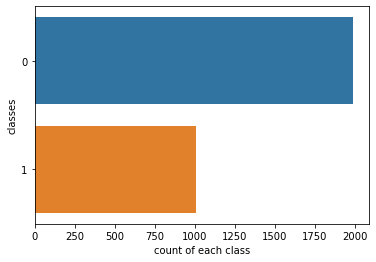

In [3]:
#Visualize Class Counts
sns.countplot(y=df.failure ,data=df) 
plt.xlabel("count of each class")
plt.ylabel("classes")
plt.show()

 - Unbalanced Dataset:
     0 labelled observations are twice the one labelled observations

## MISSING VALUES

We wanted to look for missing values in our dataset.
We noticed that the coloumn 'diameter' was the only one with at least one missing value
(because it was the only one that gave 'true' as output).

In [4]:
#in which column of our dataset is there at least a missing values?
df.isna().any()

vulc               False
perc_nat_rubber    False
wiring_strength    False
weather            False
perc_imp           False
temperature        False
tread_type         False
tyre_season        False
elevation          False
month              False
tread_depth        False
tyre_quality       False
perc_exp_comp      False
diameter            True
add_layers         False
failure            False
dtype: bool

We searched the percentage of Nan values in the diameter.
We found that it was more than 70%.
We decided to omit the diameter attribute from our analysis.

In [5]:
#percentage of NaN values in "diameter"
a=df['diameter'].isna().sum();
print("NaN value in diameter:",a)
print("Perc of NaN:", a/len(df)*100,"%")


NaN value in diameter: 2110
Perc of NaN: 70.33333333333334 %


So we can omit the diameter attribute from the analysis

We listed all the attributes: 

Attributes: 
- vulc            Numerical 
- perc_nat_rubber Numerical
- weather         Numerical
- perc_imp        Numerical
- temperature     Numerical 
- elevation       Numerical
- perc_exp_comp   Numerical
- diameter        Numerical
- tread_type      Categorical 
- tyre_season     Categorical 
- month           Categorical 
- tread_depth     Categorical 
- wiring_strenght Categorical
- tyre_quality    Categorical 
- add_layers      Categorical


Categorical attributes assume a finite number of distinct values, in most cases limited to less than a hundred, representing a qualitative property of
an entity to which they refer.
Numerical attributes assume a finite or infinite number of values and lend themselves to subtraction or division operations.

We identified the datatype of our data.
Some of the data are integers and some others are float. 

In [6]:
#come trattiamo le variabili categoriche 
print(df.dtypes)

vulc               float64
perc_nat_rubber      int64
wiring_strength      int64
weather            float64
perc_imp           float64
temperature        float64
tread_type           int64
tyre_season          int64
elevation          float64
month                int64
tread_depth          int64
tyre_quality         int64
perc_exp_comp      float64
diameter           float64
add_layers           int64
failure              int64
dtype: object


We have 7 categorical variables and 7 numerical.
We don't consider the 'diameter' because is full of Nan values. 

In [7]:
#non considero la colonna dei diametri perchè ci sono un sacco di nan e i valori non sono facili da predire 
cat=df[["tyre_season","month",          "tread_depth","wiring_strength","tyre_quality","tread_type","add_layers" ]]
num=df[["vulc",       "perc_nat_rubber","weather",    "perc_imp",       "temperature", "elevation", "perc_exp_comp"]]

print(cat.shape)
print(num.shape)

(3000, 7)
(3000, 7)


# CATEGORICAL DATA

In [8]:
cat.head()

,tyre_season,month,tread_depth,wiring_strength,tyre_quality,tread_type,add_layers
0,1,8,0,1,1,0,1
1,0,11,1,1,0,2,1
2,0,0,1,1,0,0,1
3,0,7,3,1,1,1,1
4,1,2,2,2,0,0,1


In [9]:
num.head()

,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp
0,17.990,26,0.16,0.01,-8.12,332.5,5.13
1,20.704,36,0.30,0.01,-4.52,328.0,6.15
2,19.156,34,0.30,0.01,-1.08,247.0,6.36
3,16.802,35,0.19,0.02,7.44,408.0,6.62
4,17.140,23,0.39,0.01,30.52,308.0,6.15


We plot the histograms of the seven categorical variables.

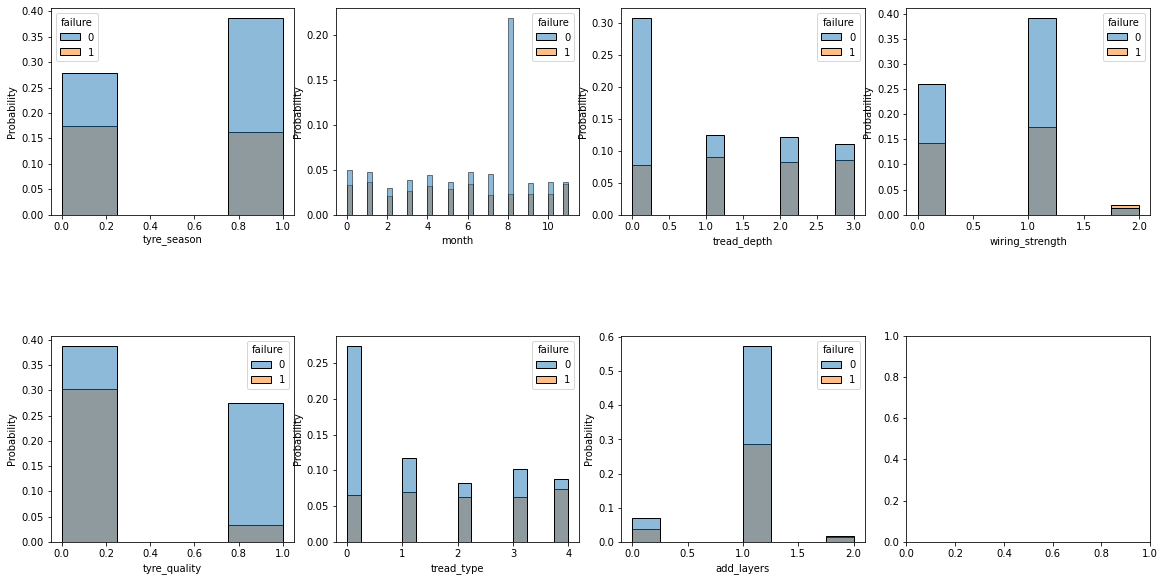

In [10]:
cat_plot=df[["tyre_season","month","tread_depth","wiring_strength","tyre_quality","tread_type","add_layers","failure"]]
fig, axes = plt.subplots(2, 4,figsize=[16,8])
axes = axes.flatten()
fig.tight_layout(h_pad=10)
i=0
for x in cat.columns:
    sns.histplot(data=cat_plot, x=x, hue="failure",stat ='probability' , ax=axes[i], binwidth=1/4 ,bins=len(set(cat_plot[x])))
    i=i+1
plt.show()

In [11]:
#categorical variables have the "object" type
#Categorical variables must be changed in the pre-processing section
#since machine learning models require numeric input variables
cat = cat.astype(str)
cat.dtypes

tyre_season        object
month              object
tread_depth        object
wiring_strength    object
tyre_quality       object
tread_type         object
add_layers         object
dtype: object

We can observe a peak of 0 labeled observations in correspondence of "month" = 8. Since there are no reasons why there should be so many more 0 labeled observations in September, we will consider "month" a noise-affected attribute.

So we try to correct month 8

In [12]:
#try to correct month 8
print(((df['month']==8) & (df['failure']==0)).sum())
print(((df['month']==8) & (df['failure']==1)).sum())

#too many items to delete o change the labels --> so i wont consider the month column 

655
69


## ENTROPY  e  GINI 

In [13]:
import collections
def CountFrequency(arr):
    return collections.Counter(arr)

def entropy(x):
    e=0
    for i in range(0,len(set(x))):
        e=e+CountFrequency(x)[i]/len(x) * np.log2( CountFrequency(x)[i]/len(x) )
    return -e 

#gini function 
def gini(x):
    tot=0
    for i in range(0,len(set(x))):
        tot=tot+ (CountFrequency(x)[i]/len(x))**2
    return 1-tot 


In [14]:
categories=['tyre_season','month','tread_depth','wiring_strength','tyre_quality','tread_type','add_layers'];

print("GINI --> 0.5 MAX ETEROGENETY\nGINI --> 0.0 MAX HOMOGENEITY**")
print("EI   --> 1   MAX ETEROGENETY\nEI   --> 0.0 MAX HOMOGENEITY**\n\n")
#gini index for categories:
for j in categories:
    print("-->",j,":\n")
    for i in set(df[j]):
        lis=(np.array([df[df[j]==i]['failure']])).astype(int)
        print(j ,"=",i) 
        print('Gini index:', round(gini(lis[0]),3), " || Entropy index:", round(entropy(lis[0]),3))
    
    print("##")
    print("\n")


GINI --> 0.5 MAX ETEROGENETY
GINI --> 0.0 MAX HOMOGENEITY**
EI   --> 1   MAX ETEROGENETY
EI   --> 0.0 MAX HOMOGENEITY**


--> tyre_season :

tyre_season = 0
Gini index: 0.474  || Entropy index: 0.962
tyre_season = 1
Gini index: 0.416  || Entropy index: 0.875
##


--> month :

month = 0
Gini index: 0.48  || Entropy index: 0.97
month = 1
Gini index: 0.491  || Entropy index: 0.987
month = 2
Gini index: 0.486  || Entropy index: 0.98
month = 3
Gini index: 0.482  || Entropy index: 0.973
month = 4
Gini index: 0.487  || Entropy index: 0.981
month = 5
Gini index: 0.492  || Entropy index: 0.988
month = 6
Gini index: 0.489  || Entropy index: 0.983
month = 7
Gini index: 0.442  || Entropy index: 0.915
month = 8
Gini index: 0.172  || Entropy index: 0.454
month = 9
Gini index: 0.476  || Entropy index: 0.965
month = 10
Gini index: 0.474  || Entropy index: 0.962
month = 11
Gini index: 0.499  || Entropy index: 0.999
##


--> tread_depth :

tread_depth = 0
Gini index: 0.321  || Entropy index: 0.724
tread

In [15]:
#month not considered 
selection_categorical=['tyre_season','tread_depth','wiring_strength','tyre_quality','tread_type','add_layers'];
dummies = pd.get_dummies(cat[selection_categorical]) 
dummies.tail()

,tyre_season_0,tyre_season_1,tread_depth_0,tread_depth_1,tread_depth_2,tread_depth_3,wiring_strength_0,wiring_strength_1,wiring_strength_2,tyre_quality_0,tyre_quality_1,tread_type_0,tread_type_1,tread_type_2,tread_type_3,tread_type_4,add_layers_0,add_layers_1,add_layers_2
2995,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0
2996,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0
2997,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0
2998,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0
2999,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0


## NUMERICAL DATA

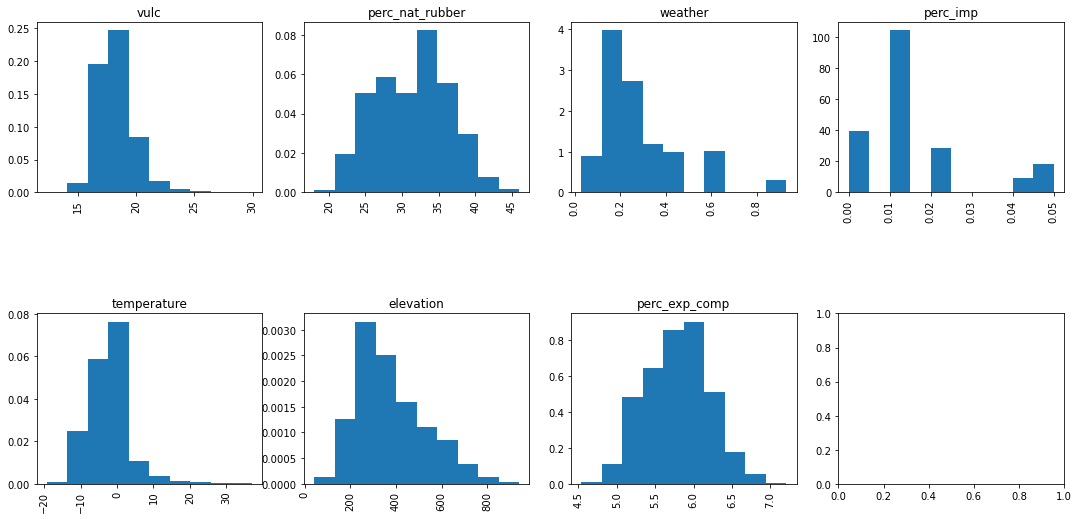

In [16]:
fig, axes = plt.subplots(2, 4,figsize=[15,7])
axes = axes.flatten()
fig.tight_layout(h_pad=10)

i=0
for x in num.columns:
    plt.sca(axes[i]) # set the current Axes
    plt.hist(num[x],density=True)
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    plt.title(x)
    i+=1
plt.show()

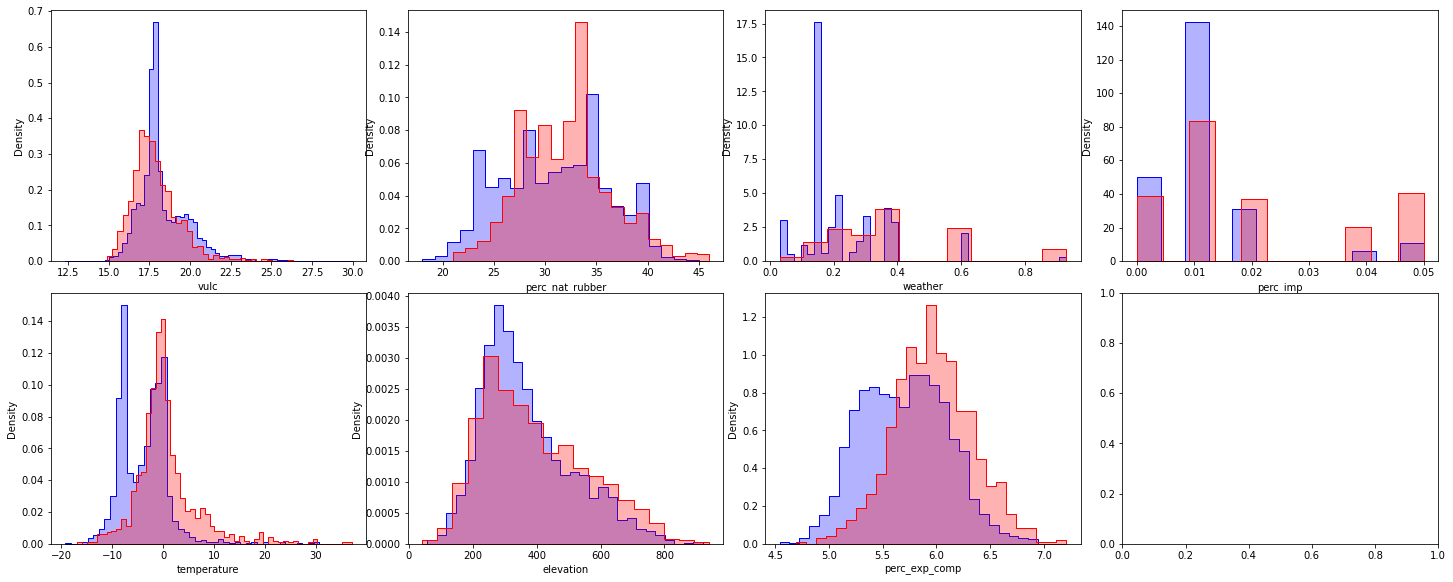

In [17]:
X0 = num[df['failure']==0]
X1 = num[df['failure']==1]

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(20,8))
fig.tight_layout()

for i, ax in zip(range(cat.columns.size), axes.flat):
    sns.histplot(X0.iloc[:,i], color="blue", ax=ax, stat='density', element="step",  alpha=0.3)
    sns.histplot(X1.iloc[:,i], color="red", ax=ax,stat='density', element="step",  alpha=0.3)
plt.show()

##provare ad applicare quache trasf

## STANDARDIZATION 

We did the standardization in order to obtain boxplots in the same range.

<AxesSubplot:>

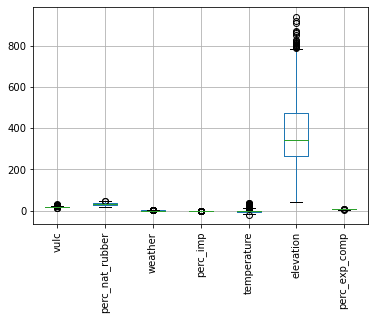

In [18]:
num.boxplot(rot=90)

#elevation has totally different numbers --> standardization 

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(num) # No target
scaled_num = pd.DataFrame(scaler.transform(num))
scaled_num.columns = num.columns
scaled_num.tail()

,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp
2995,-0.231083,-0.456093,0.584065,-0.319087,1.702514,-0.586827,-0.271809
2996,-0.698653,-0.253355,-0.343773,-1.020379,0.164930,-1.480129,0.045070
2997,-1.269567,0.354859,0.584065,-0.319087,-0.187726,-0.934222,-0.539937
2998,0.433093,1.165810,-1.380768,-1.020379,0.284834,-0.570284,0.240072
2999,1.315301,0.354859,-1.217032,-1.020379,0.912563,0.190677,0.508200


<AxesSubplot:>

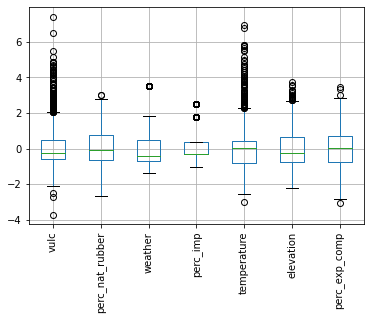

In [20]:
scaled_num.boxplot(rot=90)

#ok! 

## PCA

In [21]:
#PCA fit
from sklearn.decomposition import PCA
# we can choose the number of components e.g. 10, the percentage of the total variance or set it to None (that means it automatically chooses the number of components)
pca = PCA()
pca.fit(scaled_num) #The fit learns some quantities from the data, most importantly the "components" and "explained variance"

PCA()

In [22]:
#let's use the pca to transform the dataset
num_pca = pd.DataFrame(pca.transform(scaled_num))
num_pca.columns =['PC1','PC2','PC3','PC4','PC5','PC6','PC7']
num_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-2.039807,-1.005052,0.143276,0.280682,-0.055187,0.362670,0.070427
1,0.230444,1.339307,1.267905,-0.763265,0.159000,-0.653739,-0.277058
2,0.623754,0.939546,0.072528,-1.191816,0.466955,-0.734820,-0.208645
3,1.967707,1.162369,-1.581563,-0.294469,0.319924,-0.303452,0.923830
4,2.771142,0.328019,-2.985996,-0.799060,3.063998,3.395502,-0.162010
...,...,...,...,...,...,...,...
2995,0.625458,-0.250981,-0.783154,-0.636191,0.673647,1.360141,-0.495100
2996,-0.779224,-0.093864,-1.159095,-1.344233,0.107791,-0.019557,-0.391418
2997,-0.118266,-0.862350,-0.778459,-0.789547,-1.028185,0.076134,-0.574664
2998,-0.695504,1.737254,-0.289416,-0.992616,-0.390970,0.111279,0.471484


In [23]:
pd.DataFrame(pca.components_,index=['PC1','PC2','PC3','PC4','PC5','PC6','PC7'],columns=num.columns)

,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp
PC1,-0.080281,0.292608,0.509765,0.442437,0.469686,0.157051,0.455033
PC2,0.388180,0.472226,-0.373902,-0.496069,0.214217,0.262835,0.354203
PC3,0.796293,0.176996,0.232871,0.334312,-0.341043,0.047571,-0.223659
PC4,-0.104280,-0.256250,-0.006530,0.057527,-0.132234,0.945590,-0.092107
PC5,0.425614,-0.764839,-0.071712,0.003050,0.302535,-0.083554,0.360851
PC6,0.124018,0.013110,0.024990,-0.070775,0.705190,0.052928,-0.691896
PC7,-0.037241,0.096131,-0.735050,0.661871,0.104354,-0.008160,0.006628


In [24]:
pd.DataFrame(pca.explained_variance_).transpose()

,0,1,2,3,4,5,6
0,2.611119,1.17498,1.042926,0.946682,0.7149,0.332083,0.179644


          0         1        2         3         4         5         6
0  0.372893  0.167798  0.14894  0.135195  0.102095  0.047425  0.025655


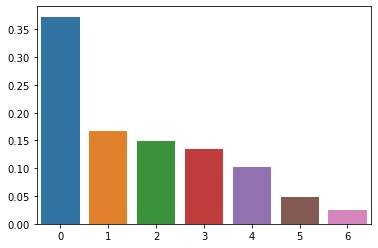

In [25]:
#VISUALIZE The percentage of variance explained by each of the selected components.
explained_var=pd.DataFrame(pca.explained_variance_ratio_).transpose()
print(explained_var)
ax = sns.barplot( data=explained_var)

In [26]:
cum_explained_var=np.cumsum(pca.explained_variance_ratio_)
cum_explained_var= pd.DataFrame(cum_explained_var).transpose()
cum_explained_var

,0,1,2,3,4,5,6
0,0.372893,0.540691,0.689631,0.824826,0.92692,0.974345,1.0


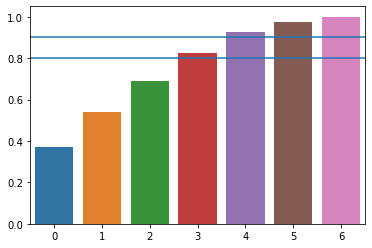

In [27]:
ax = sns.barplot(data=cum_explained_var)
ax.axhline(0.9)
ax.axhline(0.8)

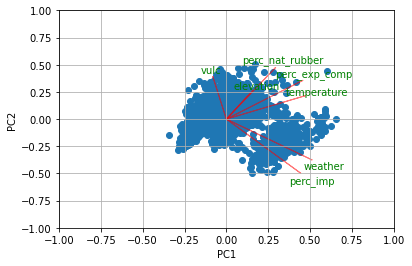

In [28]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

#Call the function. Use only the 2 PCs.
myplot(pca.transform(scaled_num)[:,0:2],np.transpose(pca.components_[0:2, :]), num.columns)
plt.show()



#perc_imp e wheater sono correlate? 

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

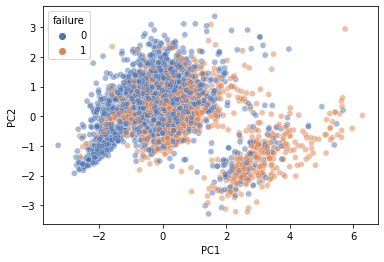

In [29]:
sns.scatterplot(x="PC1", y="PC2",
              hue=df['failure'], alpha=0.5,
              data=num_pca,
              palette='deep')

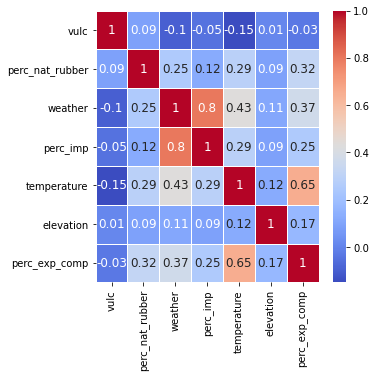

In [30]:
plt.figure(figsize = (5,5))
sns.heatmap(data=scaled_num.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()

#perc_imp e  weather !! does make it sense?

## Concatenation 

In [31]:
X=pd.concat([scaled_num,dummies], axis = 1)
print(X.shape)
X.tail()

(3000, 26)


,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp,tyre_season_0,tyre_season_1,tread_depth_0,...,tyre_quality_0,tyre_quality_1,tread_type_0,tread_type_1,tread_type_2,tread_type_3,tread_type_4,add_layers_0,add_layers_1,add_layers_2
2995,-0.231083,-0.456093,0.584065,-0.319087,1.702514,-0.586827,-0.271809,0,1,0,...,0,1,0,1,0,0,0,0,1,0
2996,-0.698653,-0.253355,-0.343773,-1.020379,0.164930,-1.480129,0.045070,0,1,0,...,1,0,0,1,0,0,0,0,1,0
2997,-1.269567,0.354859,0.584065,-0.319087,-0.187726,-0.934222,-0.539937,1,0,0,...,0,1,0,1,0,0,0,1,0,0
2998,0.433093,1.165810,-1.380768,-1.020379,0.284834,-0.570284,0.240072,1,0,1,...,1,0,0,0,0,0,1,1,0,0
2999,1.315301,0.354859,-1.217032,-1.020379,0.912563,0.190677,0.508200,1,0,0,...,1,0,0,1,0,0,0,1,0,0


In [32]:
y=df['failure']
print(len(y))

3000


In [33]:
from sklearn.model_selection import train_test_split

#SPLIT DATA INTO TRAIN AND TEST SET
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size =0.30,   
                                                    stratify=y,        #preserve target propotions (probviamo non stratificata)
                                                    random_state= 321) #fix random seed for replicability

print("FEATURE 0:" ,X_train.shape, X_test.shape)

FEATURE 0: (2100, 26) (900, 26)


In [34]:
#proportion preserved
print((y_train==0).sum())
print((y_train==1).sum())

1394
706


## Models

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics 
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

In [36]:
#funzioni 


def hyperp_search(classifier, parameters):
    gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=10, n_jobs=-1)
    gs = gs.fit(X_train, y_train)
    print("f1_train: %f using %s" % (gs.best_score_, gs.best_params_))

    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

    print("f1         train %.3f   test %.3f" % (f1_score(y_train, y_pred_train), f1_score(y_test, y_pred) )) 
    print("precision  train %.3f   test %.3f" % (precision_score(y_train, y_pred_train), precision_score(y_test, y_pred) )) 
    print("")
    print(confusion_matrix(y_test, y_pred))
    #print(classification_report(y_test, y_pred))
    return (f1_score(y_train, y_pred_train), f1_score(y_test, y_pred))

def roc(model,X_train,y_train,X_test,y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_probs = model.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

    fpr, tpr, thresholds1=metrics.roc_curve(y_test,  y_probs[:,1])

    import matplotlib.pyplot as plt
    plt.plot(fpr, tpr, label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    auc = metrics.roc_auc_score(y_test, y_probs[:,1])
    print('AUC: %.3f' % auc)
    return (fpr, tpr ,auc)

## KNN 
Whit KNN we use feature 1 beacuse the algorithm can not do features selection by it self. So we use filtered features. 

In [41]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier()
parameters = {'n_neighbors':np.arange(5,100,1)}
hyperp_search(classifier,parameters)

Fitting 3 folds for each of 95 candidates, totalling 285 fits
f1_train: 0.558235 using {'n_neighbors': 15}
f1         train 0.596   test 0.553
precision  train 0.701   test 0.635

[[513  85]
 [154 148]]


(0.5960912052117264, 0.5532710280373832)

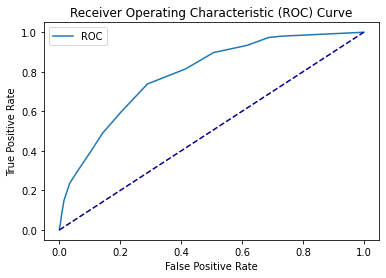

AUC: 0.788


In [43]:
model_knn = KNeighborsClassifier(n_neighbors=15)
fpr1,tpr1,AUC1=roc(model_knn,X_train,y_train,X_test,y_test)

## TREE

In [47]:
#Tree
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'], 
              'max_depth':          np.arange(2,10,1),
              'min_samples_split':  np.arange(2,20,1),
              'min_samples_leaf':   np.arange(2,40,1)}

hyperp_search(classifier,parameters)

Fitting 3 folds for each of 10944 candidates, totalling 32832 fits
f1_train: 0.530159 using {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 39, 'min_samples_split': 2}
f1         train 0.589   test 0.579
precision  train 0.711   test 0.670

[[522  76]
 [148 154]]


(0.5892116182572614, 0.5789473684210527)

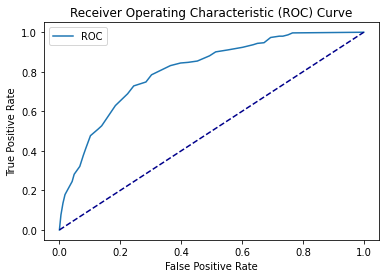

AUC: 0.807


In [48]:
model_tree = DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=39, min_samples_split=2)

fpr2,tpr2,AUC2=roc(model_tree,X_train,y_train,X_test,y_test)


## Naive Bayes

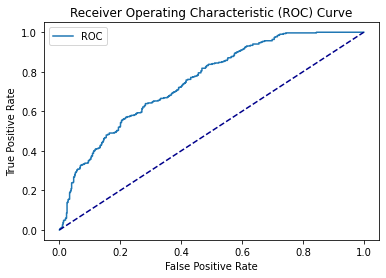

AUC: 0.752


In [49]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB #or alternative NB implementations

model = GaussianNB()

model.fit(X_train, y_train)
y_pred=model.predict(X_test)



y_probs = model.predict_proba(X_test) 
fpr3,tpr3,AUC3=roc(model,X_train,y_train,X_test,y_test)

## Logistic

In [51]:
# Logistic

from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
parameters = {"C":np.arange(1,10,1), "max_iter":[1000] }


hyperp_search(classifier,parameters)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
f1_train: 0.542723 using {'C': 9, 'max_iter': 1000}
f1         train 0.541   test 0.596
precision  train 0.640   test 0.669

[[518  80]
 [140 162]]


(0.5412919051512675, 0.5955882352941176)

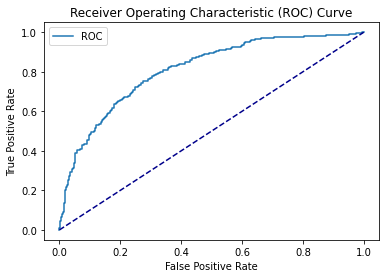

AUC: 0.810


In [52]:
model = LogisticRegression(C=9, max_iter=1000)

fpr4,tpr4,AUC4=roc(model,X_train,y_train,X_test,y_test)


## SUPPORT VECTOR MACHINE

In [53]:
from sklearn.svm import SVC

classifier = SVC()
parameters = {"kernel":['linear','sigmoid','rbf'],
              "C":[0.001,0.005,0.1,0.5,50,60,70,80]}

hyperp_search(classifier,parameters)


#OVER-FITTING: using {'C': 50, 'kernel': 'rbf'}
# so we omit the 'rbf' among the possible parameters. 

Fitting 3 folds for each of 24 candidates, totalling 72 fits
f1_train: 0.557433 using {'C': 0.1, 'kernel': 'sigmoid'}
f1         train 0.558   test 0.574
precision  train 0.569   test 0.572

[[468 130]
 [128 174]]


(0.5578034682080926, 0.5742574257425742)

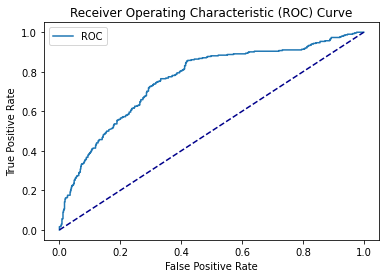

AUC: 0.760


In [54]:
model = SVC(C=0.1, kernel='sigmoid',probability=True)

fpr5,tpr5,AUC5=roc(model,X_train,y_train,X_test,y_test)

## NEURAL NETWORK

In [39]:
# Multi-layer Perceptron classifier

from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()
parameters = {"hidden_layer_sizes":[(14,7),(10, 5),(20, 10, 5),(50,10,5)], 
              "max_iter": [2000],
              "alpha": [0.001,0.01,1],
              "activation":['identity', 'logistic', 'tanh', 'relu'],
              "solver":    ['lbfgs', 'sgd', 'adam'],
              "learning_rate":['constant', 'invscaling', 'adaptive']}

hyperp_search(classifier,parameters)

#over fitting with: 'alpha': 0.1, 'hidden_layer_sizes': (100, 20, 5), 'max_iter': 2000
#over fitting 

Fitting 3 folds for each of 3 candidates, totalling 9 fits
f1_train: 0.560905 using {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (20, 10, 5), 'learning_rate': 'adaptive', 'max_iter': 2000, 'solver': 'sgd'}
f1         train 0.588   test 0.608
precision  train 0.670   test 0.652

[[506  92]
 [130 172]]


(0.588235294117647, 0.607773851590106)

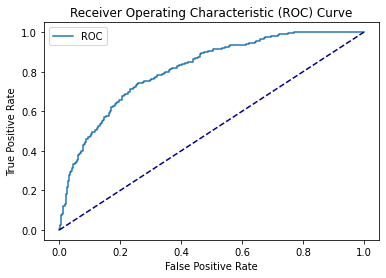

AUC: 0.813


In [41]:
model_MLP=MLPClassifier(activation='relu',
                        alpha= 0.001,
                        hidden_layer_sizes= (20,10, 5),
                        learning_rate= 'adaptive',
                        max_iter= 2000,
                        solver='sgd')

fpr6,tpr6,AUC6=roc(model_MLP,X_train,y_train,X_test,y_test)

## RANDOM FOREST 

In [41]:
from sklearn.ensemble import RandomForestClassifier


classifier= RandomForestClassifier()
parameters = {'n_estimators' :     np.arange(22,27,1),
              'criterion' :        ['entropy', 'gini'],
              'max_depth' :        np.arange(2,8 ,1), 
              'min_samples_split': np.arange(2,20,1),
              'min_samples_leaf' : np.arange(2,40,1)
             };

hyperp_search(classifier,parameters)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
f1_train: 0.534211 using {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 24}
f1         train 0.626   test 0.581
precision  train 0.806   test 0.726

[[543  55]
 [156 146]]


(0.6256499133448874, 0.58051689860835)

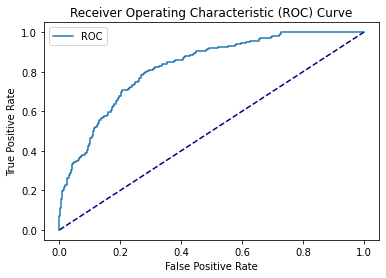

AUC: 0.825


In [45]:
rand_forest=RandomForestClassifier(criterion= 'gini', max_depth= 7, min_samples_leaf= 4, min_samples_split= 6, n_estimators= 24)
fpr7,tpr7,AUC7=roc(rand_forest,X_train,y_train,X_test,y_test)

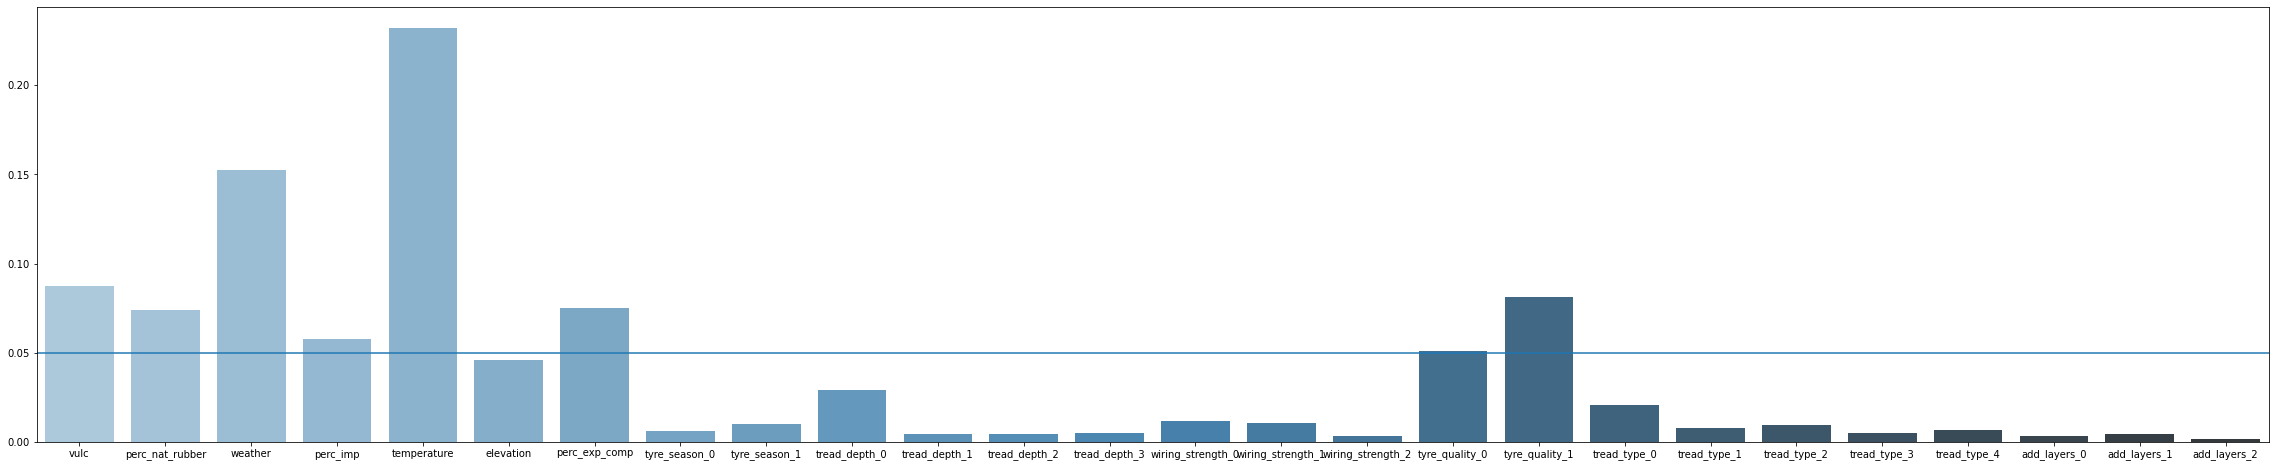

In [46]:
fig, axes = plt.subplots(figsize=[40,8])
graph=sns.barplot(x=X_train.columns, y=rand_forest.feature_importances_, palette="Blues_d")
graph.axhline(0.05)

## ADA BOOST 

In [690]:
from sklearn.ensemble import AdaBoostClassifier


classifier= AdaBoostClassifier()
parameters = {'n_estimators'  : [2000,3000,5000,6000],
              'learning_rate' : [0.0001, 0.01, 0.1, 1, 10],
              'algorithm': ['SAMME', 'SAMME.R']}

hyperp_search(classifier,parameters)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
f1_train: 0.551411 using {'algorithm': 'SAMME.R', 'learning_rate': 0.01, 'n_estimators': 3000}
f1         train 0.587   test 0.557
precision  train 0.673   test 0.633

[[511  87]
 [152 150]]


(0.5873902633679169, 0.5565862708719852)

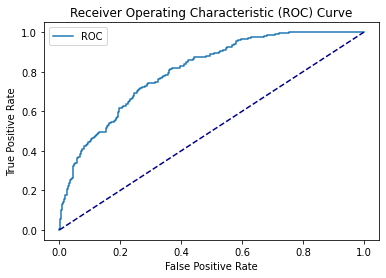

AUC: 0.804


In [691]:
AdaBoost_clf=AdaBoostClassifier(learning_rate= 0.01, n_estimators= 3000,algorithm='SAMME.R')
fpr8,tpr8,AUC8=roc(AdaBoost_clf,X_train,y_train,X_test,y_test)

## ROC CURVE COMPARISON 

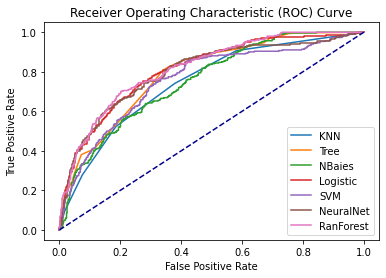

In [583]:
plt.plot(fpr1, tpr1, label= "KNN")
plt.plot(fpr2, tpr2, label= "Tree") 
plt.plot(fpr3, tpr3, label= "NBaies")   
plt.plot(fpr4, tpr4, label= "Logistic")
plt.plot(fpr5, tpr5, label= "SVM")
plt.plot(fpr6, tpr6, label= "NeuralNet")
plt.plot(fpr7, tpr7, label= "RanForest")
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [702]:
AUC=[AUC1,AUC2,AUC3,AUC4,AUC5,AUC6,AUC7]

In [704]:
print(AUC)

[0.7440419499878181, 0.7896603468515361, 0.7524889809298103, 0.8095915745642207, 0.7595793926775786, 0.8167733504618042, 0.8201953531639682]


|Model|AUC|F1_TRAIN|F1_TEST|
|---|---|---|---|
|KNN|0.74|0.69|0.55|
|Tree|0.81|0.59|0.58|
|NBaies|0.75|NaN|NaN|
|Logistic|0.81|0.54|0.60|
|SVM|0.76|0.56|0.58|
|NeuralNet|0.82|0.59|0.61|
|RanForest|0.82|0.63|0.58|
|adaBoost|0.80|0.59|0.56|